In [9]:
from pathlib import Path
import sys

# More reliable: get the project root from the notebook's location
ROOT_PATH = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
# Or even better for notebooks:
ROOT_PATH = Path().resolve().parent  # Goes up from notebooks/ folder

sys.path.append(str(ROOT_PATH))

from src.data.dataset import OrionAEFrameDataset

train_set =  OrionAEFrameDataset(
    data_path = r"F:\orion-ae-study\data\raw\segmented_cycles_positive_c1_l42373_c_A_B_C_D_20251220_154951",
    config_path= r"F:\orion-ae-study\configs\dataset\example_1.yaml",
)

ae_signal = train_set[0]['raw']
ae_signal = ae_signal[1]

In [10]:
# train_set[4000]

## Apply Hanning Window to reduce edge effects

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def apply_hanning_window(signal):
    """
    Apply Hanning window to reduce edge effects
    
    Parameters:
    -----------
    signal : array
        Input AE signal
        
    Returns:
    --------
    windowed_signal : array
        Signal after Hanning window multiplication
    """
    hanning_window = np.hanning(len(signal))
    windowed_signal = signal * hanning_window
    return windowed_signal

# Apply CWT to build Scalogram

In [12]:
from ssqueezepy import cwt

def morse_wavelet_scales(fs, n_scales=12, freq_min=50e3, freq_max=2.5e6, gamma=3, beta=60):
    """
    Generate log-spaced scales for Morse wavelet using ssqueezepy
    
    Parameters:
    -----------
    fs : float
        Sampling frequency
    n_scales : int
        Number of scales (12 as in paper)
    freq_min, freq_max : float
        Frequency range to cover
    gamma : float
        Morse wavelet gamma parameter (default: 3)
    beta : float
        Morse wavelet beta parameter (default: 60, equivalent to P=60)
        
    Returns:
    --------
    scales : array
        Log-spaced scales
    frequencies : array
        Corresponding frequencies
    """
    # For Morse wavelet, convert frequency range to scale range
    # Using ssqueezepy's scale computation
    # Peak frequency factor for Morse wavelet
    peak_freq_factor = (beta / (gamma + 1)) ** (1.0 / gamma)
    
    # Convert frequency range to scale range
    scale_max = peak_freq_factor * fs / (2 * np.pi * freq_min)
    scale_min = peak_freq_factor * fs / (2 * np.pi * freq_max)
    
    # Log-spaced scales
    scales = np.logspace(np.log10(scale_min), np.log10(scale_max), n_scales)
    
    # Corresponding frequencies
    frequencies = peak_freq_factor * fs / (2 * np.pi * scales)
    
    return scales, frequencies

def compute_cwt_morse(signal, fs=5e6, n_scales=12):
    """
    Compute CWT using Analytic Morse wavelet (gamma=3, beta=60) via ssqueezepy
    
    Parameters:
    -----------
    signal : array
        Input signal (Hanning-windowed)
    fs : float
        Sampling frequency
    n_scales : int
        Number of scales (filter bank size)
        
    Returns:
    --------
    cwt_coeffs : array (n_scales × n_samples)
        CWT coefficients (complex)
    frequencies : array
        Corresponding frequencies
    """
    # Morse wavelet parameters as specified in paper
    # Note: ssqueezepy uses 'beta' instead of 'P', where beta = P
    gamma = 3
    beta = 60  # Equivalent to P=60 in the paper
    
    # Generate scales based on frequency range
    # For AE sensors, typical range is 50 kHz to 2.5 MHz
    freq_min = 50e3
    freq_max = 2.5e6
    scales, frequencies = morse_wavelet_scales(fs, n_scales, freq_min, freq_max, gamma, beta)
    
    # Compute CWT using ssqueezepy with Generalized Morse Wavelet
    # 'gmw' is the Generalized Morse Wavelet (Morse wavelet)
    Wx, scales_computed, *_ = cwt(
        signal,
        wavelet=('gmw', {'gamma': gamma, 'beta': beta}),
        scales=scales,  # Use our computed scales
        fs=fs,
        l1_norm=True,  # L1 normalization (energy preserving)
        vectorized=True
    )
    
    # ssqueezepy returns Wx as (n_scales, n_samples) complex array
    # frequencies are computed from scales
    # Recompute frequencies from actual scales used
    peak_freq_factor = (beta / (gamma + 1)) ** (1.0 / gamma)
    frequencies = peak_freq_factor * fs / (2 * np.pi * scales_computed)
    
    return Wx, frequencies

def apply_custom_colormap(magnitude_2d):
    """
    Apply custom colormap: blue → green → yellow
    
    Parameters:
    -----------
    magnitude_2d : array (224 × 224)
        Grayscale magnitude values [0, 255]
        
    Returns:
    --------
    rgb_image : array (224 × 224 × 3)
        RGB image with custom colormap
    """
    # Normalize to [0, 1]
    norm = magnitude_2d / 255.0
    
    # Use matplotlib colormap (fixed deprecation warning)
    from matplotlib import colormaps
    colormap = colormaps['viridis']  # Fixed: was cm.get_cmap('viridis')
    rgb_image = (colormap(norm)[:, :, :3] * 255).astype(np.uint8)
    
    return rgb_image

def create_scalogram_image(cwt_coeffs, frequencies, target_size=(224, 224)):
    """
    Convert CWT coefficients to 224×224 RGB scalogram image
    
    Parameters:
    -----------
    cwt_coeffs : array (n_scales × n_samples)
        CWT coefficients
    frequencies : array
        Frequency vector
    target_size : tuple
        Target image size (224, 224)
        
    Returns:
    --------
    scalogram_rgb : array (224 × 224 × 3)
        RGB scalogram image (uint8)
    """
    # Take magnitude
    magnitude = np.abs(cwt_coeffs)
    
    # Resize to 224×224 using PIL
    from PIL import Image
    
    # Normalize to [0, 255]
    magnitude_norm = magnitude / (np.max(magnitude) + 1e-10)
    magnitude_8bit = (magnitude_norm * 255).astype(np.uint8)
    
    # Resize using PIL (better interpolation than scipy)
    img = Image.fromarray(magnitude_8bit, mode='L')
    # Use Resampling enum for newer PIL versions, fallback for older versions
    try:
        img_resized = img.resize((target_size[1], target_size[0]), Image.Resampling.BILINEAR)
    except AttributeError:
        # Fallback for older PIL versions
        img_resized = img.resize((target_size[1], target_size[0]), Image.BILINEAR)
    
    # Convert to RGB with colormap (blue-green-yellow as in paper)
    magnitude_resized = np.array(img_resized)
    
    # Apply colormap (blue=low, green=medium, yellow=high)
    scalogram_rgb = apply_custom_colormap(magnitude_resized)
    
    return scalogram_rgb

def ae_cycle_to_scalogram(ae_signal, fs=5e6, n_scales=12, target_size=(224, 224)):
    """
    Complete pipeline: AE signal → Scalogram RGB image
    
    Parameters:
    -----------
    ae_signal : array
        Raw AE signal for one cycle
    fs : float
        Sampling frequency (5 MHz)
    n_scales : int
        Number of wavelet scales (12)
    target_size : tuple
        Output image size (224, 224)
        
    Returns:
    --------
    scalogram_rgb : array (224 × 224 × 3)
        RGB scalogram image ready for CNN
    cwt_coeffs : array
        CWT coefficients (for analysis)
    frequencies : array
        Frequency vector
    """
    # Step 1: Apply Hanning window
    windowed_signal = apply_hanning_window(ae_signal)
    
    # Step 2: Compute CWT with Morse wavelet
    cwt_coeffs, frequencies = compute_cwt_morse(windowed_signal, fs, n_scales)
    
    # Step 3: Create 224×224 RGB scalogram
    scalogram_rgb = create_scalogram_image(cwt_coeffs, frequencies, target_size)
    
    return scalogram_rgb, cwt_coeffs, frequencies

def visualize_pipeline(ae_signal, fs=5e6):
    """
    Visualize the complete pipeline
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    t = np.arange(len(ae_signal)) / fs
    
    # Original signal
    axes[0, 0].plot(t * 1000, ae_signal)
    axes[0, 0].set_title('Raw AE Signal')
    axes[0, 0].set_xlabel('Time (ms)')
    axes[0, 0].set_ylabel('Amplitude (mV)')
    
    # Hanning windowed signal
    windowed = apply_hanning_window(ae_signal)
    axes[0, 1].plot(t * 1000, windowed)
    axes[0, 1].set_title('After Hanning Window')
    axes[0, 1].set_xlabel('Time (ms)')
    axes[0, 1].set_ylabel('Amplitude (mV)')
    
    # CWT magnitude
    cwt_coeffs, frequencies = compute_cwt_morse(windowed, fs)
    axes[1, 0].imshow(np.abs(cwt_coeffs), aspect='auto', cmap='viridis',
                       extent=[0, len(ae_signal)/fs*1000, frequencies[-1]/1e6, frequencies[0]/1e6])
    axes[1, 0].set_title('CWT Magnitude (12 scales)')
    axes[1, 0].set_xlabel('Time (ms)')
    axes[1, 0].set_ylabel('Frequency (MHz)')
    axes[1, 0].set_yscale('log')
    
    # Final 224×224 scalogram
    scalogram_rgb, _, _ = ae_cycle_to_scalogram(ae_signal, fs)
    axes[1, 1].imshow(scalogram_rgb, aspect='auto')
    axes[1, 1].set_title('224×224 RGB Scalogram')
    axes[1, 1].set_xlabel('Time (normalized to 224 pixels)')
    axes[1, 1].set_ylabel('Frequency (log, normalized to 224 pixels)')
    
    plt.tight_layout()
    plt.show()

In [13]:
scalogram_rgb, cwt_coeffs, frequencies = ae_cycle_to_scalogram(
    ae_signal, 
    fs=5e6, 
    n_scales=12, 
    target_size=(224, 224)
)

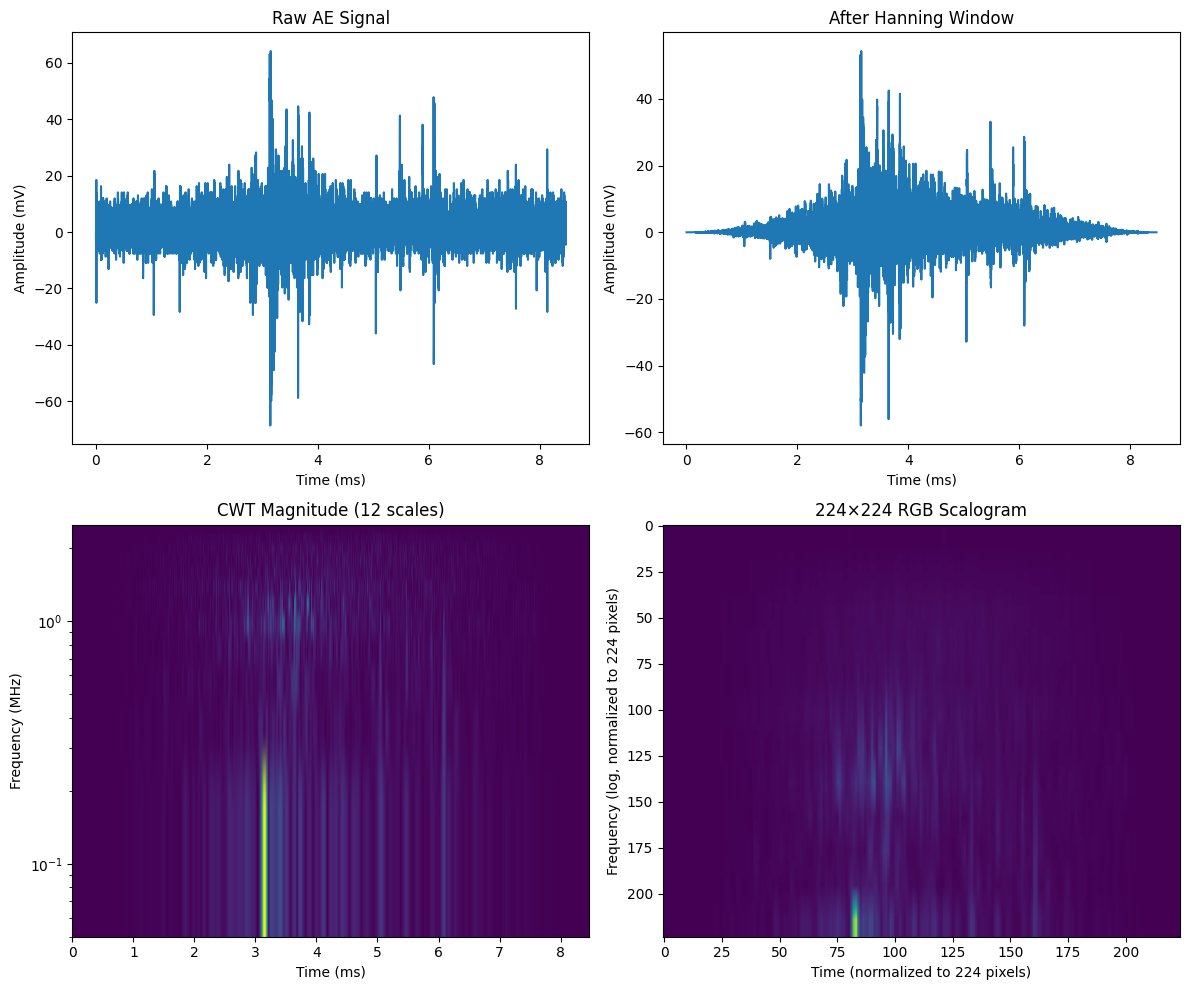

In [14]:
visualize_pipeline(ae_signal, fs=5e6)

In [15]:
from PIL import Image
# Ensure array is uint8 and has correct shape
if scalogram_rgb.dtype != np.uint8:
    scalogram_rgb = scalogram_rgb.astype(np.uint8)
img = Image.fromarray(scalogram_rgb)

In [16]:
scalogram_rgb

array([[[68,  1, 84],
        [68,  1, 84],
        [68,  1, 84],
        ...,
        [68,  1, 84],
        [68,  1, 84],
        [68,  1, 84]],

       [[68,  1, 84],
        [68,  1, 84],
        [68,  1, 84],
        ...,
        [68,  1, 84],
        [68,  1, 84],
        [68,  1, 84]],

       [[68,  1, 84],
        [68,  1, 84],
        [68,  1, 84],
        ...,
        [68,  1, 84],
        [68,  1, 84],
        [68,  1, 84]],

       ...,

       [[68,  1, 84],
        [68,  1, 84],
        [68,  1, 84],
        ...,
        [68,  1, 84],
        [68,  1, 84],
        [68,  1, 84]],

       [[68,  1, 84],
        [68,  1, 84],
        [68,  1, 84],
        ...,
        [68,  1, 84],
        [68,  1, 84],
        [68,  1, 84]],

       [[68,  1, 84],
        [68,  1, 84],
        [68,  1, 84],
        ...,
        [68,  1, 84],
        [68,  1, 84],
        [68,  1, 84]]], shape=(224, 224, 3), dtype=uint8)